In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

dataset = pd.read_csv("/content/drive/MyDrive/ESAA/OB_dataset/car_evaluation.csv")
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


컴퓨터는 인간의 언어인 단어를 인식할 수 없기 때문에 단어를 벡터로 바꾸는 임베딩 처리가 필요하다.

<Axes: ylabel='count'>

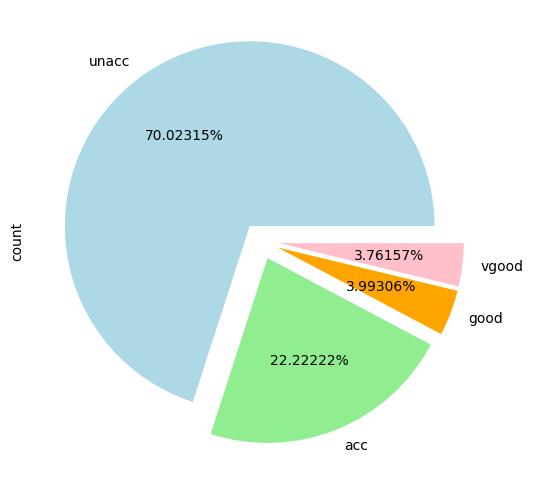

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind="pie", autopct = '%0.05f%%',
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'],
                                   explode = [0.1, 0.1, 0.1, 0.1])


결과: 대부분(70%)의 자동차는 허용불가능한 상태에 있고 20%만 허용가능한 수준

**데이터를 범주형 타입으로 변환**

범주 특성을 갖는 데이터를 범주형 타입으로 변환. 또한 범주형 타입을 텐서로 변환 (참고: 이 데이터는 모두 범주형 데이터임)

범주형 데이터 > dataset[category] > 넘파이 배열 > tensor

- 범주형 데이터(단어)를 숫자(넘파이 배열)로 변환하기 위해 cat.codes를 사용한다.
- np.stak은 두 개 이상의 넘파이 객체를 합칠 때 사용한다.

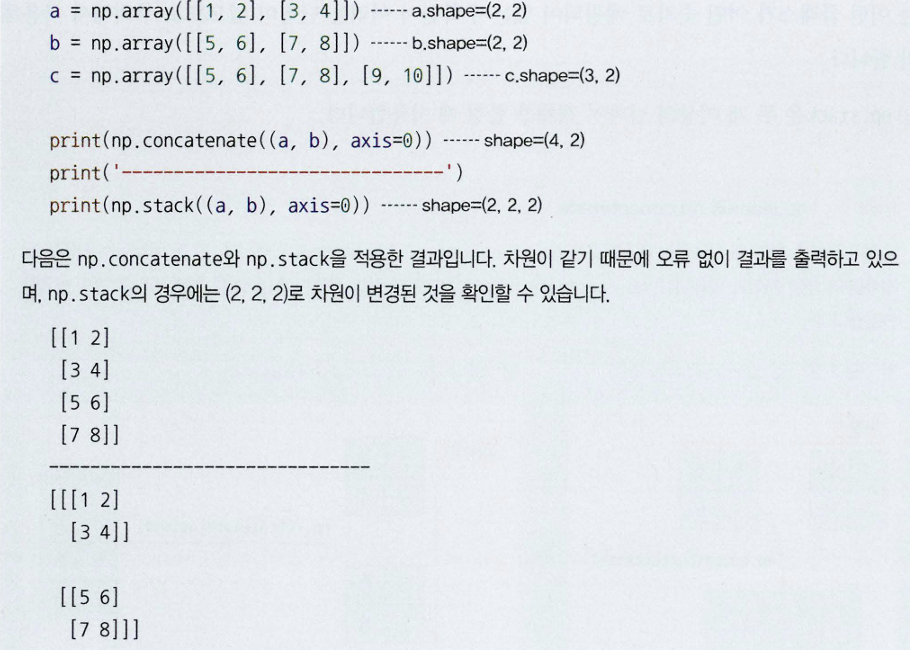

In [5]:
# 데이터를 범주형 타입으로 변환

categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [6]:
# 배열을 텐서로 변환

categorical_data = torch.tensor(categorical_data, dtype = torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [7]:
# 레이블로 사용할 칼럼을 텐서로 변환
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() #1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [8]:
# get_dummies 예시

data = {
    'gender' : ['male', 'female', 'male'],
    'weight' : [72, 55, 68],
    'nation' : ['Japan', 'Korea', 'Australia']
}

df = pd.DataFrame(data)
df

#성별과 국적을 숫자로 변환
pd.get_dummies(df)

,weight,gender_female,gender_male,nation_Australia,nation_Japan,nation_Korea
0,72,False,True,False,True,False
1,55,True,False,False,False,True
2,68,False,True,True,False,False


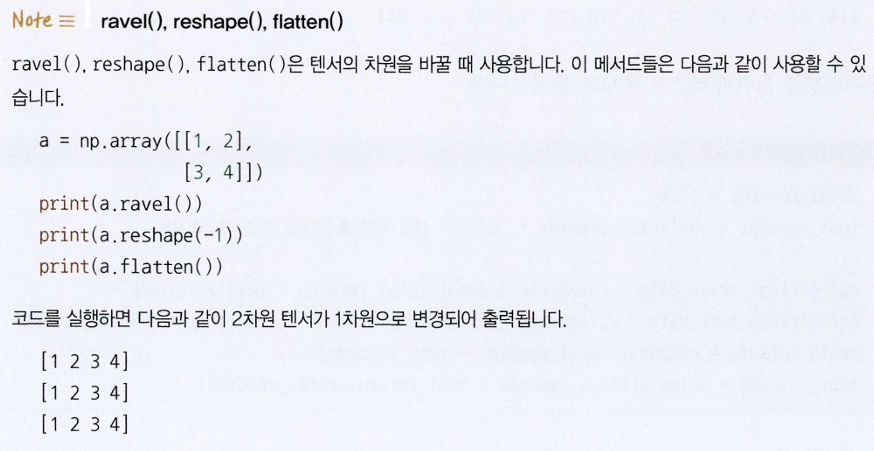

워드 임베딩: 유사한 단어끼리 유사하게 인코딩되도록 표현하는 방법
- 높은 차원의 임베딩일수록 단어 간의 세부적인 관계를 잘 파악할 수 있음. 따라서 단일 숫자로 변환된 넘파이 배열을 N차원으로 변경하여 사용
- 배열을 N차원으로 변환하기 위해 모든 범주형 칼럼에 대한 임베딩 크기를 정의한다. 정확한 규칙은 없지만 칼럼의 고유값 수를 2로 나누는 것을 많이 사용

In [10]:
# 범주형 칼럼을 n차원으로 변환

categorical_column_sizes = [len(dataset[column].cat.categories) for column in
                            categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in
                              categorical_column_sizes ]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [11]:
# 데이터셋 분리
total_records = 1728
test_records = int(total_records * .2) #전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [13]:
# 데이터셋 분리 확인
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [14]:
# 모델의 네트워크 생성
class Model(nn.Module): ### 1
    def __init__(self, embedding_size, output_size, layers, p=0.4): ### 2
        super().__init__() ### 3
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,
                                     nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols #입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size 변수에 저장

        for i in layers: ### 4
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical): ### 5
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
           embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) #넘파이의 concatenate와 같지만 대상이 텐서
        x = self.embedding_dropout(x)
        x = self.layers(x)

        return x

1. nn.Module을 상속받음
2. __init__()은 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도로 사용하며, 객체가 생성될 때 자동으로 호출된다. __init__()에서 전달되는 매개변수는 다음과 같다.
> self, embedding_size, output_size, layers, p=0.4

- self: 첫번째 파라미터는 self를 지정해야하며 자기 자신을 의미한다.
- embedding_size: 범주형 칼럼의 임베딩 크기
- output_size: 출력층의 크기
- layers : 모든 계층에 대한 목록
- p: 드롭아웃(기본값은 0.5)

3. super().__init__(): 부모클래스(nn.Module)에 접근할 때 사용

4. 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가
- Linear: 선형 계층은 입력 데이터에 선형 변환을 진행한 결과. 입력과 가중치를 곱한 후 바이어스를 더한 결과
- ReLU: 활성화 함수로 사용
- BatchNorm1d: 배치 정규화 용도로 사용
- Dropout: 과적합 방지에 사용

5. forward() 함수는 학습 데이터를 입력받아서 연산을 진행. forward()함수는 모델 객체를 데이터와 함께 호출하면 자동으로 실행됨

In [15]:
# Model 클래스의 객체 생성
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [16]:
# 모델의 파라미터 정의

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
# CPU, GPU 사용 지정

if torch.cuda.is_available():
    device = torch.device('cuda') # GPU가 있다면 GPU를 사용
else:
    device = torch.device('cpu') # GPU가 없다면 CPU를 사용

In [22]:
# 모델 학습

epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs): # for문은 500회 반복되며, 각 반복마다 손실 함수가 오차를 계산
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 aggregated_losses에 추가

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward() # 가중치를 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트


print(f'epoch: {i:3} loss: {single_loss.item():10.10f}') # 오차가 25 에포크마다 출력

epoch:   1 loss: 0.50862461
epoch:  26 loss: 0.51328295
epoch:  51 loss: 0.50069249
epoch:  76 loss: 0.50357640
epoch: 101 loss: 0.48430726
epoch: 126 loss: 0.49421555
epoch: 151 loss: 0.47348094
epoch: 176 loss: 0.48057091
epoch: 201 loss: 0.46312302
epoch: 226 loss: 0.49335590
epoch: 251 loss: 0.46982843
epoch: 276 loss: 0.47626671
epoch: 301 loss: 0.46912199
epoch: 326 loss: 0.48176318
epoch: 351 loss: 0.47761598
epoch: 376 loss: 0.47026533
epoch: 401 loss: 0.47055712
epoch: 426 loss: 0.47260457
epoch: 451 loss: 0.45599863
epoch: 476 loss: 0.46551889
epoch: 500 loss: 0.4570616186


In [23]:
# 테스트 데이터셋으로 모델 예측

test_outputs = test_outputs.to(device = device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.49656165


In [24]:
# 모델의 예측 확인
print(y_val[:5])

tensor([[ 3.8911,  2.7395, -7.0180, -6.7268],
        [ 3.9392,  2.3754, -6.7656, -6.7065],
        [ 3.9472,  2.6401, -7.6382, -7.2881],
        [ 2.6028,  1.2969, -4.1459, -4.1937],
        [ 3.1703,  2.1152, -5.8053, -5.3091]])


In [25]:
# 가장 큰 값을 갖는 인덱스 확인

y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [26]:
# 테스트 데이터셋을 이용한 정확도 확인
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       259
           1       0.53      0.28      0.37        86

    accuracy                           0.76       345
   macro avg       0.66      0.60      0.61       345
weighted avg       0.73      0.76      0.73       345

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       259
           1       0.53      0.28      0.37        86

    accuracy                           0.76       345
   macro avg       0.66      0.60      0.61       345
weighted avg       0.73      0.76      0.73       345

0.7594202898550725


- True Positive: 모델(분류기)이 '1'이라고 예측했는데 실제 값도 '1'인 경우
- True Negative: 모델(분류기)이 '0'이라고 예측했는데 실제 값도 '0'인 경우
- False Positive: 모델(분류기)이 '1'이라고 예측했는데 실제 값도 '0'인 경우 > 1종의 오류
- False Negative: 모델(분류기)이 '0'이라고 예측했는데 실제 값도 '1'인 경우 > 2종 오류

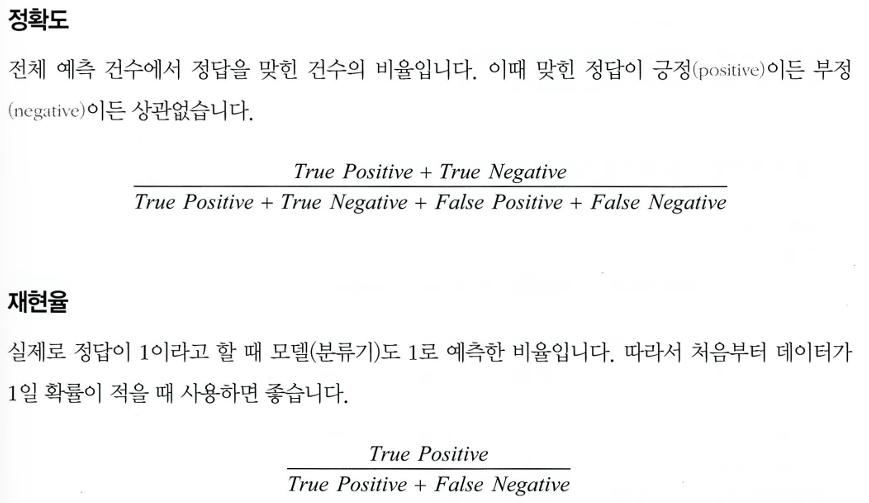

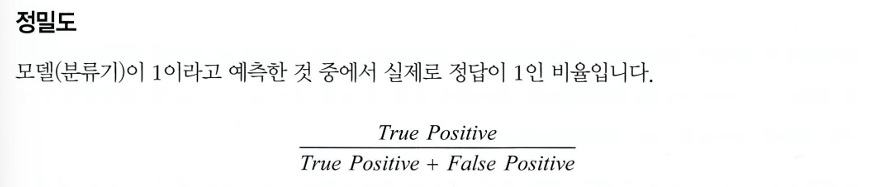

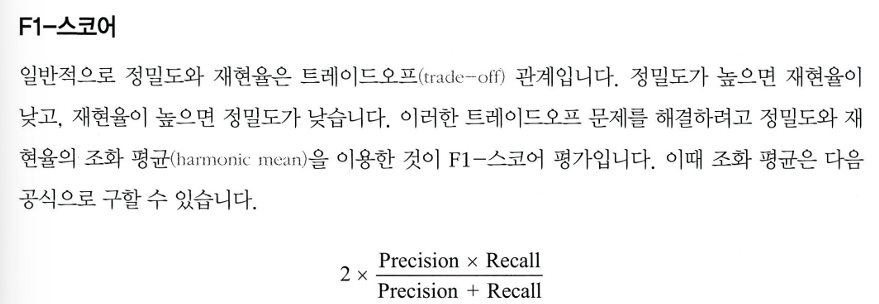